In [1]:
!pip install instructor httpx==0.27.2 graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found existing installation: jiter 0.8.0
    Uninstalling jiter-0.8.0:
      Successfully uninstalled jiter-0.8.0
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.0
    Uninstalling httpx-0.28.0:
      Successfully uninstalled httpx-0.28.0


In [2]:
import instructor
from openai import OpenAI
from typing import Iterable, List, Optional
from enum import Enum
from pydantic import BaseModel
import os
from google.colab import userdata

In [3]:
class PriorityEnum(str, Enum):
    high = "High"
    medium = "Medium"
    low = "Low"


class Subtask(BaseModel):
    """Correctly resolved subtask from the given transcript"""

    id: int
    name: str


class Ticket(BaseModel):
    """Correctly resolved ticket from the given transcript"""

    id: int
    name: str
    description: str
    priority: PriorityEnum
    assignees: List[str]
    subtasks: Optional[List[Subtask]]
    dependencies: Optional[List[int]]




In [4]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [19]:
# Apply the patch to the OpenAI client
# enables response_model keyword
client = instructor.from_openai(OpenAI())

def generate(data: str) -> Iterable[Ticket]:
    return client.chat.completions.create(
        model="gpt-4",
        response_model=Iterable[Ticket],
        messages=[
            {
                "role": "system",
                "content": "The following is a transcript of a meeting...",
            },
            {
                "role": "user",
                "content": f"Create the action items for the following transcript: {data}",
            },
        ],
    )

In [82]:
tickets = generate(
    """
Alice: Hey team, we have several critical tasks we need to tackle for the upcoming release. First, we need to work on improving the authentication system. It's a top priority.
Bob: Got it, Alice. I can take the lead on the authentication improvements. Are there any specific areas you want me to focus on?
Alice: Good question, Bob. We need both a front-end revamp and back-end optimization. So basically, two sub-tasks.
Carol: I can help with the front-end part of the authentication system.
Bob: Great, Carol. I'll handle the back-end optimization then.
Alice: Perfect. Now, after the authentication system is improved, we have to integrate it with our new billing system. That's a medium priority task.
Carol: Is the new billing system already in place?
Alice: No, it's actually another task. So it's a dependency for the integration task. Bob, can you also handle the billing system?
Bob: Sure, but I'll need to complete the back-end optimization of the authentication system first, so it's dependent on that.
Alice: Understood. Lastly, we also need to update our user documentation to reflect all these changes. It's a low-priority task but still important.
Carol: I can take that on once the front-end changes for the authentication system are done. So, it would be dependent on that.
Alice: Sounds like a plan. Let's get these tasks modeled out and get started."""
)

In [83]:
tickets[0]

Ticket(id=1, name='Improve Authentication System', description='Work on improving the authentication system. Include a front-end revamp and back-end optimization.', priority=<PriorityEnum.high: 'High'>, assignees=['Bob', 'Carol'], subtasks=[Subtask(id=2, name='Front-end Revamp'), Subtask(id=3, name='Back-end Optimization')], dependencies=None)

In [84]:
import json

In [85]:
tickets_json = json.dumps(tickets, default=lambda o: o.__dict__, indent=4)
print(tickets_json)

[
    {
        "id": 1,
        "name": "Improve Authentication System",
        "description": "Work on improving the authentication system. Include a front-end revamp and back-end optimization.",
        "priority": "High",
        "assignees": [
            "Bob",
            "Carol"
        ],
        "subtasks": [
            {
                "id": 2,
                "name": "Front-end Revamp"
            },
            {
                "id": 3,
                "name": "Back-end Optimization"
            }
        ],
        "dependencies": null
    },
    {
        "id": 4,
        "name": "Integrate Authentication with new Billing System",
        "description": "Integrate the improved authentication system with the new billing system.",
        "priority": "Medium",
        "assignees": [
            "Bob"
        ],
        "subtasks": null,
        "dependencies": [
            1,
            5
        ]
    },
    {
        "id": 5,
        "name": "Implement New Billing 

In [86]:
from graphviz import Digraph

In [87]:
# Convert the JSON data to a Graphviz object
def tasks_to_graphviz(tasks):
    dot = Digraph(comment='Project Tasks')

    # Create a node for each task
    for task in tasks:
        node_label = f"{task['name']}\nPriority: {task['priority']}\Description: {task['description']}\nAssignees: {task['assignees']}"
        dot.node(str(task['id']), label=node_label, shape='rect', style='filled', fillcolor='lightyellow')

        # Create nodes for subtasks
        if task['subtasks']:
            for subtask in task['subtasks']:
                subtask_label = subtask['name']
                dot.node(str(subtask['id']), label=subtask_label)
                dot.edge(str(task['id']), str(subtask['id']))  # Link main task to subtasks

    # Create edges for dependencies
    for task in tasks:
        if task['dependencies']:
            for dep_id in task['dependencies']:
                dot.edge(str(dep_id), str(task['id']))  # Link dependency to the current task

    return dot

# Create the Graphviz object
graphviz_dot = tasks_to_graphviz(json.loads(tickets_json))

In [88]:
print("Graphviz DOT Representation:")
print(graphviz_dot.source)

Graphviz DOT Representation:
// Project Tasks
digraph {
	1 [label="Improve Authentication System
Priority: High\Description: Work on improving the authentication system. Include a front-end revamp and back-end optimization.
Assignees: ['Bob', 'Carol']" fillcolor=lightyellow shape=rect style=filled]
	2 [label="Front-end Revamp"]
	1 -> 2
	3 [label="Back-end Optimization"]
	1 -> 3
	4 [label="Integrate Authentication with new Billing System
Priority: Medium\Description: Integrate the improved authentication system with the new billing system.
Assignees: ['Bob']" fillcolor=lightyellow shape=rect style=filled]
	5 [label="Implement New Billing System
Priority: High\Description: Implement the new billing system.
Assignees: ['Bob']" fillcolor=lightyellow shape=rect style=filled]
	6 [label="Update User Documentation
Priority: Low\Description: Update the user documentation to reflect changes in the authentication and billing systems.
Assignees: ['Carol']" fillcolor=lightyellow shape=rect style=fi

In [89]:
# Render and output the graph
graphviz_dot.render('project_tasks_graph', format='png', cleanup=True)


'project_tasks_graph.png'

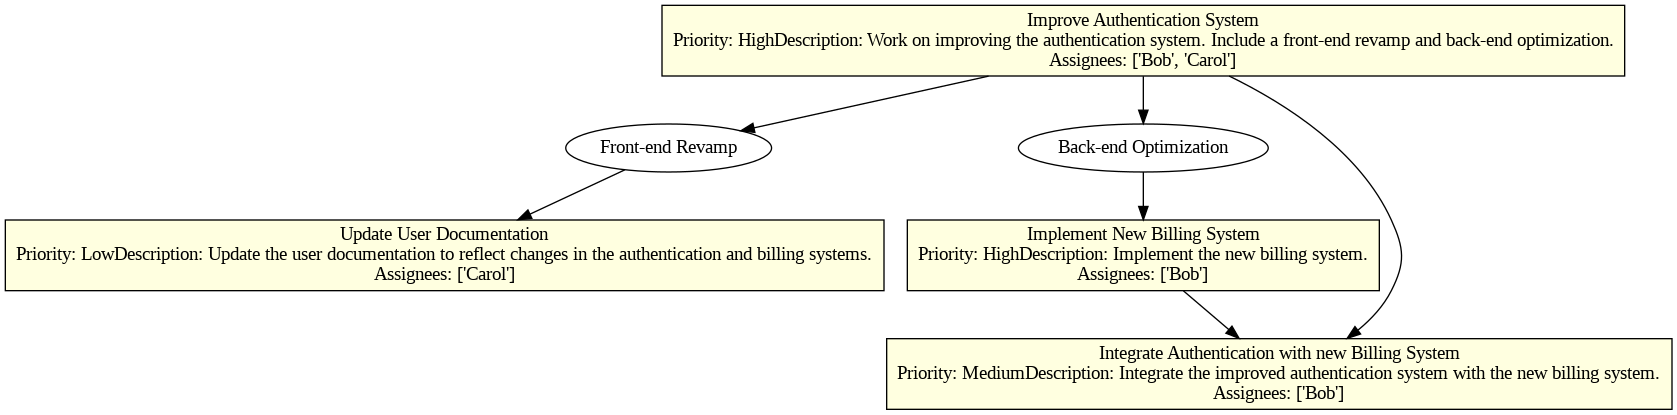

In [90]:
from IPython.display import Image, display

# Display the generated PNG image
display(Image(filename='/content/project_tasks_graph.png'))